# Dealing with infrequent apps

In [1]:
from spmf import Spmf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import ast
pd.options.plotting.backend = "plotly"
import plotly.express as px
from chart_studio import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.subplots as sp
pd.options.display.max_colwidth = None
pd.set_option('display.max_rows', 70)

## Dealing with infrequency as defined by tne number of session in which an app occur

First the data is read into the program

In [2]:
data=pd.read_csv("data_sessions_20s_min_length_1.csv")

Now the number of sessions which each of the apps occure in is calculated.

In [5]:
app_in_n_sessions=data.groupby(['app_code','user_id']).session.nunique().reset_index().groupby("app_code").session.sum()

In [6]:
data=pd.merge(data, app_in_n_sessions.reset_index().rename(columns={'session':'number_of_sessions'}), how='left', on=['app_code'])

In [7]:
data['app_infrequent']=data.number_of_sessions<=(data.shape[0]/100*0.001)

In [8]:
data.shape[0]

181323205

In [9]:
data['new_session']=(data.new_session | data.app_infrequent)

In [10]:
data['updated_session']=data.groupby(['user_id']).agg({'new_session':'cumsum'}).astype('int')

In [11]:
data=data[data.app_infrequent!=True]

In [12]:
data=pd.merge(data,(data.groupby(['user_id','updated_session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','updated_session'])

In [13]:
data=data.drop(['session_length'],axis=1)

In [16]:
data=data[data.session_length_updated>1]

Create text file for algorithm input

In [17]:
input_string=data.groupby(['user_id','updated_session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [18]:
#update file name
input_string.to_csv("input_string_without_0_001_apps_internal_removed.csv",index=False)

In [2]:
#update file name
input_string=pd.read_csv("input_string_without_0_001_apps_internal_removed.csv")

In [19]:
print("number of updated sequences:",input_string.shape[0])

number of updated sequences: 55164865


In [3]:
dfAsString = input_string.to_string(header=False, index=False).lstrip()

In [4]:
dfAsString=re.sub(r'\n\s+','\n',dfAsString)

In [5]:
#update file name
f = open(os.path.join(os.getcwd(), '20sec_sessions_without_0_001_apps_internal_removed.txt'), 'w')
f.write(dfAsString)
f.close()

## Analysing frequency of apps in overall data set.

In [2]:
data=pd.read_csv("sorted_coded_session_20s_merged.csv")

First we take a look at the distribution of app occurrences.

In [3]:
app_count=data.groupby('app_code').size()

In [4]:
print("min number of times an app occure:",app_count.min())
print("max number of times an app occure:",app_count.max())

min number of times an app occure: 1
max number of times an app occure: 35121339


In [9]:
print("Number of apps which occure only once:",app_count[app_count==1].sum())
print("Number of apps:",app_count.shape[0])

Number of apps which occure only once: 15442
Number of apps: 67088


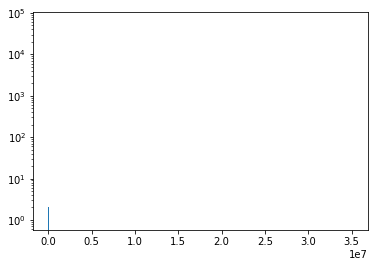

In [51]:
plt.hist(app_count,bins=range(1,app_count.max(),200))
plt.yscale('log')

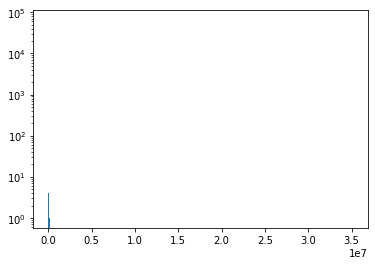

In [116]:
bins=plt.hist(app_count,bins=range(1,app_count.max()+660,1000))
plt.yscale('log')

It is clear that the majority of apps are not used that many time.

In [121]:
app_count.quantile(q=.99)

9870.650000000023

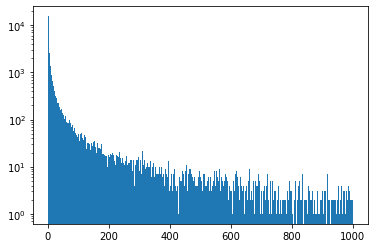

In [122]:
bins=plt.hist(app_count,bins=range(1,1001,1))
plt.yscale('log')
plt.y

We now take a look at how many apps constitute at least one percent of the observations.

In [130]:
print("Number of apps which constitute at least one percent of the observations",((app_count/data.shape[0]*100)>=1).sum())

Number of apps which constitute at least one percent of the observations 17


In [135]:
print("number of observations:",data.shape[0])

number of observations: 250615269


However ~2.5 mio. obervations is still a high number.

In [139]:
print("Number of apps which constitute at least 0.1 percent of the observations",((app_count/data.shape[0]*100)>=0.1).sum())
print("Number of apps which constitute at least 0.01 percent of the observations",((app_count/data.shape[0]*100)>=0.01).sum())

Number of apps which constitute at least 0.1 percent of the observations 69
Number of apps which constitute at least 0.01 percent of the observations 329


It is overall clear that the majority of observations is made up of only a small number of differnet apps.

How many apps are needed in order to maintain 90 procent of the observations?

In [12]:
app_count=app_count.sort_values(ascending=False)

In [15]:
print("number of apps needed to represent 90% of the observations:",app_count.shape[0]-((app_count/data.shape[0]*100).cumsum())[((app_count/data.shape[0]*100).cumsum()).shift(1)>=90].shape[0])
print("number of apps needed to represent 95% of the observations:",app_count.shape[0]-((app_count/data.shape[0]*100).cumsum())[((app_count/data.shape[0]*100).cumsum()).shift(1)>=95].shape[0])
print("number of apps needed to represent 99% of the observations:",app_count.shape[0]-((app_count/data.shape[0]*100).cumsum())[((app_count/data.shape[0]*100).cumsum()).shift(1)>=99].shape[0])
print("number of apps needed to represent 99.5% of the observations:",app_count.shape[0]-((app_count/data.shape[0]*100).cumsum())[((app_count/data.shape[0]*100).cumsum()).shift(1)>=99.5].shape[0])
print("number of apps needed to represent 99.9% of the observations:",app_count.shape[0]-((app_count/data.shape[0]*100).cumsum())[((app_count/data.shape[0]*100).cumsum()).shift(1)>=99.9].shape[0])

number of apps needed to represent 90% of the observations: 125
number of apps needed to represent 95% of the observations: 483
number of apps needed to represent 99% of the observations: 3780
number of apps needed to represent 99.5% of the observations: 6791
number of apps needed to represent 99.9% of the observations: 18872


In [28]:
print("Number of observations removed if by only keeping apps, to maintain 90 % of the observations: ",data.shape[0]-(data.shape[0]/100*90))

Number of observations removed if by only keeping apps, to maintain 90 % of the observations:  25061526.900000006


In [16]:
print("Number of observations removed if by only keeping apps, to maintain 95 % of the observations: ",data.shape[0]-(data.shape[0]/100*95))

Number of observations removed if by only keeping apps, to maintain 95 % of the observations:  12530763.450000018


In [175]:
print("Number of observations removed if by only keeping apps, to maintain 99.5 % of the observations: ",data.shape[0]-(data.shape[0]/100*99.5))

Number of observations removed if by only keeping apps, to maintain 99.5 % of the observations:  1253076.3449999988


In [13]:
print("Number of observations removed if by only keeping apps, to maintain 99 % of the observations: ",data.shape[0]-(data.shape[0]/100*99))

Number of observations removed if by only keeping apps, to maintain 99 % of the observations:  2506152.6899999976


We now identify the apps to maintain.

In [43]:
((app_count/data.shape[0]*100).cumsum())[((app_count/data.shape[0]*100).cumsum()).shift(1)>=99.5]

app_code
45282     99.500156
55589     99.500253
10137     99.500350
16495     99.500447
46754     99.500544
            ...    
34475     99.999998
34474     99.999999
7853      99.999999
2950     100.000000
67087    100.000000
Length: 60297, dtype: float64

In [14]:
infrequent_apps=app_count[(app_count/data.shape[0]*100).cumsum().shift(1)>=99].index

Now that the infrequent apps have been identified, the infrequent apps can be removed. This is done after the definition of sessions, as the sleeptime should not be affected. 

In [15]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv") #all sessions of length one have already been removed.

In [31]:
data_sessions[data_sessions.app_code.apply(lambda l: l in infrequent_apps)]#from 90%

,package_name,user_id,start_time,end_time,time_spend,app_code,sequence_number,sequence_Start_time,sequence_end_time,sleep_time,new_session,session,session_length
10,bg.abv.andro.emailapp,0,3689,3699,10,2340,11,3669,3926,0,False,2,6
26,bg.abv.andro.emailapp,0,33562,33586,24,2340,28,33562,33586,0,False,9,2
28,bg.abv.andro.emailapp,0,44088,44098,10,2340,31,44088,44098,0,False,11,2
31,com.adobe.reader,0,46384,46404,20,6577,35,46384,46404,100,True,14,3
42,bg.abv.andro.emailapp,0,49406,49416,10,2340,49,49406,49416,0,False,19,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181322972,com.americanexpress.android.acctsvcs.uk,9999,28784240,28784260,20,7464,14640,28784240,28784260,101,True,8343,7
181322974,uk.co.ee.myee,9999,28784290,28784330,40,65645,14642,28784290,28784330,10,False,8343,7
181322977,com.americanexpress.android.acctsvcs.uk,9999,28785031,28785081,50,7464,14645,28785031,28785081,10,False,8343,7
181323025,com.instagram.layout,9999,28964716,28964756,40,27447,14705,28964716,28964756,0,False,8372,3


In [33]:
print("Percentage of observations to delete from dataframe:",18455397/data_sessions.shape[0]*100) #from 95 

Percentage of observations to delete from dataframe: 10.178177139544825


In [16]:
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)

In [17]:
data_sessions['new_session']=(data_sessions.new_session | data_sessions.infrequent_app)

In [18]:
data_sessions['updated_session']=data_sessions.groupby(['user_id']).agg({'new_session':'cumsum'}).astype('int')

In [19]:
data_sessions=data_sessions[data_sessions.infrequent_app!=True]

In [20]:
print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 179487135


In [21]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','updated_session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','updated_session'])

In [22]:
data_sessions=data_sessions.drop(['session_length'],axis=1)

In [23]:
data_sessions=data_sessions[data_sessions.session_length_updated>1]

In [24]:
print("number of observations:",data_sessions.shape[0])

number of observations: 178335525


After the removal of infrequent apps, the text filed used for running the mining algorithms can now be created.

In [25]:
input_string=data_sessions.groupby(['user_id','updated_session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [26]:
#update file name
input_string.to_csv("input_string_apps_removed_to_keep_99.csv",index=False)

In [2]:
input_string=pd.read_csv("input_string_apps_removed_to_keep_99.csv")

In [3]:
print("number of updated sequences:",input_string.shape[0])

number of updated sequences: 55880352


In [4]:
dfAsString = input_string.to_string(header=False, index=False).lstrip()

In [5]:
dfAsString=re.sub(r'\n\s+','\n',dfAsString)

In [6]:
#update file name
f = open(os.path.join(os.getcwd(), '20sec_sessions_apps_removed_to_keep_99.txt'), 'w')
f.write(dfAsString)
f.close()

## Runing mining algorithms

In [5]:
# A test using there package 
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_apps_removed_to_keep_95.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20s_sessions_keep_95_min_sup_10.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.1])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20s_sessions_keep_95_min_sup_10.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 330383 ms
 Frequent sequences count : 7
 Max memory (mb) : 16813.142089843757
minsup 5354046
Intersection count 0 


   pattern       sup
0  [53003]  14658663
1  [45264]   8075606
2  [27441]   5997022
3  [23949]   8859267
4  [19973]   7254103
5  [19968]  19810204
6   [7649]  13943608


In [6]:
# A test using there package 
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_apps_removed_to_keep_95.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20s_sessions_keep_95_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20s_sessions_keep_95_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 591591 ms
 Frequent sequences count : 72
 Max memory (mb) : 18338.40190124511772
minsup 535405
Intersection count 370 


                  pattern      sup
0                 [53996]  1072874
1                 [45846]  1594140
2                 [45284]   860325
3                 [45246]   774930
4                 [36529]   784571
..                    ...      ...
67  [19968, 19968, 19968]   576962
68   [23949, 7649, 23949]  1176340
69   [19968, 23949, 7649]   614466
70   [19968, 7649, 19968]   763404
71    [7649, 23949, 7649]   597054

[72 rows x 2 columns]


In [7]:
# A test using there package 
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_apps_removed_to_keep_95.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20s_sessions_keep_95_min_sup_0_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.001])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20s_sessions_keep_95_min_sup_0_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 2527159 ms
 Frequent sequences count : 1007
 Max memory (mb) : 18203.4273910522461007
minsup 53541
Intersection count 9801 


                                         pattern     sup
0                                        [66375]   81889
1                                        [66136]  134133
2                                        [65957]   99466
3                                        [65471]  129106
4                                        [65457]   59695
...                                          ...     ...
1002  [53003, 53003, 19968, 53003, 19968, 53003]   54507
1003  [19968, 53003, 19968, 53003, 19968, 53003]   64567
1004  [53003, 19968, 53003, 19968, 53003, 19968]   72251
1005    [23949, 7649, 23949, 23949, 7649, 23949]   60633
1006     [23949, 7649, 23949, 7649, 23949, 7649]   73553

[1007 rows x 2 columns]


## Translating results

In [8]:
data = pd.read_csv('sorted_coded_data.csv')
app_dict=dict(zip(data.app_code, data.package_name))

In [13]:
output=pd.read_csv("output_VMSP_20s_sessions_keep_95_min_sup_10.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_20s_sessions_keep_95_min_sup_10_translated.csv",index=False)

In [14]:
output=pd.read_csv("output_VMSP_20s_sessions_keep_95_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_20s_sessions_keep_95_min_sup_1_translated.csv",index=False)

In [17]:
output=pd.read_csv("output_VMSP_20s_sessions_keep_95_min_sup_0_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_20s_sessions_keep_95_min_sup_0_1_translated.csv",index=False)

## Defining infrequency based on percentage of occurences.

In [2]:
data=pd.read_csv("sorted_coded_session_20s_merged.csv")

In [3]:
app_count=data.groupby('app_code').size()

In [4]:
app_count=app_count.sort_values(ascending=False)

In [12]:
infrequent_apps=app_count[app_count/data.shape[0]*100<0.01].index

In [14]:
print("number of infrequent apps for 0.01 thresshold:",len(infrequent_apps))

number of infrequent apps for 0.01 thresshold: 66759


In [9]:
print("The 90-quantile in percent:",9870.650000000023/data.shape[0]*100)

The 90-quantile in percent: 0.003938566887558644


In [15]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv") #all sessions of length one have already been removed.

In [16]:
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)

In [17]:
data_sessions['new_session']=(data_sessions.new_session | data_sessions.infrequent_app)

In [18]:
data_sessions['updated_session']=data_sessions.groupby(['user_id']).agg({'new_session':'cumsum'}).astype('int')

In [19]:
data_sessions=data_sessions[data_sessions.infrequent_app!=True]

In [20]:
print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 169980345


In [21]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','updated_session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','updated_session'])

In [22]:
data_sessions=data_sessions.drop(['session_length'],axis=1)

In [23]:
data_sessions=data_sessions[data_sessions.session_length_updated>1]

In [24]:
print("number of observations:",data_sessions.shape[0])

number of observations: 163122437


In [25]:
input_string=data_sessions.groupby(['user_id','updated_session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [28]:
input_string.to_csv("input_string_apps_0_01_removed.csv",index=False)

In [2]:
input_string=pd.read_csv("input_string_apps_0_01_removed.csv")

In [4]:
print("number of updated sequences:",input_string.shape[0])

number of updated sequences: 52838635


In [3]:
dfAsString = input_string.to_string(header=False, index=False).lstrip()

In [4]:
dfAsString=re.sub(r'\n\s+','\n',dfAsString)
#update file name
f = open(os.path.join(os.getcwd(), '20sec_sessions_0_01_removed.txt'), 'w')
f.write(dfAsString)
f.close()

In [5]:
# A test using there package 
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_0_01_removed.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_0_01_removed_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20sec_sessions_0_01_removed_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 541111 ms
 Frequent sequences count : 72
 Max memory (mb) : 14146.80473327636772
minsup 528387
Intersection count 370 


                  pattern      sup
0                 [53996]  1065566
1                 [45846]  1581664
2                 [45284]   851696
3                 [45246]   766567
4                 [36529]   777709
..                    ...      ...
67  [19968, 19968, 19968]   558475
68   [23949, 7649, 23949]  1172511
69   [19968, 23949, 7649]   609083
70   [19968, 7649, 19968]   752957
71    [7649, 23949, 7649]   590476

[72 rows x 2 columns]


In [6]:
data = pd.read_csv('sorted_coded_data.csv')
app_dict=dict(zip(data.app_code, data.package_name))

In [2]:
output=pd.read_csv("output_VMSP_20sec_sessions_0_01_removed_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_20sec_sessions_0_01_removed_min_sup_1_translated.csv",index=False)

NameError: name 'app_dict' is not defined

In [3]:
output=pd.read_csv("output_VMSP_20sec_sessions_0_01_removed_min_sup_1_translated.csv")

In [5]:
len(output[output.pattern_length==1])

11

# Tunning infrequency threshold.
Doing this procedure min. sup. is kept to 1%

In [2]:
data=pd.read_csv("sorted_coded_session_20s_merged.csv")
app_count=data.groupby('app_code').size()
app_count=app_count.sort_values(ascending=False)

In [3]:
infrequent_apps=app_count[app_count/data.shape[0]*100<0.001].index
print("Number of infrequent apps:",len(infrequent_apps))

Number of infrequent apps: 65408


In [4]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv")
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)
data_sessions['new_session']=(data_sessions.new_session | data_sessions.infrequent_app)
data_sessions['updated_session']=data_sessions.groupby(['user_id']).agg({'new_session':'cumsum'}).astype('int')
data_sessions=data_sessions[data_sessions.infrequent_app!=True]
print("Number of observations after infrequent apps have been removed:",data_sessions.shape[0])

Number of observations after infrequent apps have been removed: 177469828


In [5]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','updated_session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','updated_session'])
data_sessions=data_sessions.drop(['session_length'],axis=1)
data_sessions=data_sessions[data_sessions.session_length_updated>1]
print("number of observations:",data_sessions.shape[0])

number of observations: 175056848


In [6]:
input_string=data_sessions.groupby(['user_id','updated_session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
input_string.to_csv("input_string_apps_0_001_removed.csv",index=False)
print("number of updated sequences:",input_string.shape[0])

number of updated sequences: 55253900


In [2]:
input_string=pd.read_csv("input_string_apps_0_001_removed.csv")
dfAsString = input_string.to_string(header=False, index=False).lstrip()
dfAsString=re.sub(r'\n\s+','\n',dfAsString)
#update file name
f = open(os.path.join(os.getcwd(), '20sec_sessions_0_001_removed.txt'), 'w')
f.write(dfAsString)
f.close()

In [3]:
# A test using there package 
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_0_001_removed.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_0_001_removed_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20sec_sessions_0_001_removed_min_sup_1.csv")

CalledProcessError: Command '['java', '-jar', '/home/s164574/motifs_and_competition_in_app_usage/spmf.jar', 'run', 'VMSP', '/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_0_001_removed.txt', '/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_0_001_removed_min_sup_1.txt', '0.01']' returned non-zero exit status 1.

In [ ]:
data = pd.read_csv('sorted_coded_data.csv')
app_dict=dict(zip(data.app_code, data.package_name))

In [ ]:
output=pd.read_csv("output_VMSP_20sec_sessions_0_001_removed_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_20sec_sessions_0_001_removed_min_sup_1_translated.csv",index=False)

In [ ]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

In [2]:
tunning_results=pd.read_csv("Tunninf Infrequency threshold.csv")

In [3]:
tunning_results=tunning_results[:16]

In [4]:
tunning_results=tunning_results[1:]

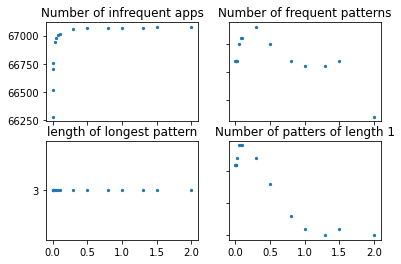

In [5]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(tunning_results['threshold(%)'],tunning_results['num of infrequency apps'],s=5)
axs[0, 0].set_title('Number of infrequent apps')
axs[0, 1].scatter(tunning_results['threshold(%)'],tunning_results['num of frequent patterns founded'],s=5)
axs[0, 1].set_title('Number of frequent patterns')
axs[1, 0].scatter(tunning_results['threshold(%)'],tunning_results['max length of founded pattern'],s=5)
axs[1, 0].set_title('length of longest pattern')
axs[1, 1].scatter(tunning_results['threshold(%)'],tunning_results['num of length 1 founded pattern '],s=5)
axs[1, 1].set_title('Number of patters of length 1')

#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
#plt.scatter(tunning_results['threshold(%)'],tunning_results['num of infrequency apps'])

In [12]:
fig1 =px.scatter(tunning_results,x='threshold(%)', y='num of infrequency apps',title = 'Number of infrequent apps')
fig2 =px.scatter(tunning_results,x='threshold(%)', y='num of frequent patterns founded',title = 'Number of frequent patterns')
fig3 =px.scatter(tunning_results,x='threshold(%)', y='max length of founded pattern',title = 'length of longest pattern')
fig4 = px.scatter(tunning_results,x='threshold(%)', y='num of length 1 founded pattern ',title='Number of patters of length 1')

In [13]:
fig2

In [14]:
fig1

In [9]:
fig3

In [10]:
fig4

In [11]:
figure1 = px.scatter(tunning_results,x='threshold(%)', y='num of infrequency apps')
figure2 = px.scatter(tunning_results,x='threshold(%)', y='num of frequent patterns founded')
figure3 = px.scatter(tunning_results,x='threshold(%)', y='max length of founded pattern')
figure4 = px.scatter(tunning_results,x='threshold(%)', y='num of length 1 founded pattern ')


figure1_traces = []
figure2_traces = []
figure3_traces = []
figure4_traces = []
for trace in range(len(figure1["data"])):
    figure1_traces.append(figure1["data"][trace])
for trace in range(len(figure2["data"])):
    figure2_traces.append(figure2["data"][trace])
for trace in range(len(figure3["data"])):
    figure3_traces.append(figure3["data"][trace])
for trace in range(len(figure4["data"])):
    figure4_traces.append(figure4["data"][trace])    
#Create a 1x2 subplot
this_figure = sp.make_subplots(rows=2, cols=2) 

# Get the Express fig broken down as traces and add the traces to the proper plot within in the subplot
for traces in figure1_traces:
    this_figure.append_trace(traces, row=1, col=1)
for traces in figure2_traces:
    this_figure.append_trace(traces, row=1, col=2)
for traces in figure3_traces:
    this_figure.append_trace(traces, row=2, col=1)
for traces in figure4_traces:
    this_figure.append_trace(traces, row=2, col=2)

#the subplot as shown in the above ima

In [37]:
this_figure